# Final Project: Prey Predator: The invasion 
## Author: Dor Cohen
## Instractor: Dr Yoav Ram

### **Background**
In class we discussed the simple prey predator model summrized by the lotka-volterra equations which allowed us to  

In this project we will discuss a more complicated scenario where there are 2 populations of predators differnt in their hunting rate. In the begining of this scenrio there is a big population of predator $y_1$ and a small population of $y_2$ but $h_1<h_2$.

In nature scenrio like this happens when there are mutaion which make the hunting rate better or if a invasive species appears.

In [6]:
from functools import partial

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import scipy
from scipy.integrate import solve_bvp, solve_ivp, odeint
from ipywidgets import interact

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


The equations are: 

$\frac{dx}{dt} = bx - (h_1y_1+h_2y_2)x$

$\frac{dy_1}{dt} = \epsilon_1h_1xy_1 - d_1y_1$

$\frac{dy_2}{dt} = \epsilon_2h_2xy_2 -d_2y_2$

Where the parameters are:

x - prey 

b - birth rate of prey

$y_1$ - native predator

$h_1$ - native predator hunting rate

$\epsilon_1$ - native predator "ingestion rate"

$d_1$ - the native predator death rate

$y_2$ - invasive predator

$h_2$ - invasive predator hunting rate

$\epsilon_2$ - invasive predator "ingestion rate"

$d_2$ - the invasive predator death rate


For simplicity I'll assume that the invasive predator has only different hunting rate. The differnet huning rate gives the invasive predator evolutionary advantage  

Therefore, $\epsilon_1=\epsilon_2=\epsilon$ and $d_1=d_2=d$

The equations will be:

$\frac{dx}{dt} = bx - (h_1y_1+h_2y_2)x$

$\frac{dy_1}{dt} = \epsilon h_1xy_1 - dy_1$

$\frac{dy_2}{dt} = \epsilon h_2xy_2 -dy_2$

In [7]:
def dxy1y2dt(t, xy1y2, b, h1, h2, ϵ, d):
    x, y1, y2 = xy1y2
    dx = b * x - (h1*y1+h2*y2)*x
    dy1 = ϵ * h1 * x * y1 - d * y1
    dy2 = ϵ * h2 * x * y2 - d * y2
    return np.array([dx, dy1, dy2])

## Numerical solution with for loop :

In [8]:
# model parameters
b = 1
h1 = 0.005
h2 = 0.006
ϵ = 0.8
d = 0.6

steps = 100000 # number integration steps
xy = np.empty((3, steps)) # population array
xy[:,0] = 50, 100, 5
dt = 0.001 # time step for integration
for t in range(1, steps):
    xy[:, t] = xy[:, t-1] + dxy1y2dt(t, xy[:, t-1], b, h1, h2, ϵ, d) * dt
x = xy[0, :]
y1 = xy[1, :]
y2 = xy[2, :]
t = np.arange(0, dt * steps, dt)

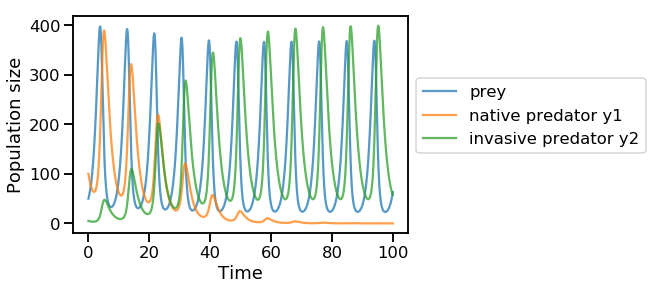

In [9]:
plt.plot(t, x, alpha=0.75, label='prey')
plt.plot(t, y1, alpha=0.75, label='native predator y1')
plt.plot(t,y2, alpha=0.75, label='invasive predator y2')
plt.xlabel('Time')
plt.ylabel('Population size')
# bbox_to_anchor places the legend at specific position, in this case outside the plot
plt.legend(bbox_to_anchor=(1, 0.75));

We can see that the native predator was extincted. This is with just ~16% hunting advantage. 

## Using SciPy

### Let's calculate the Jacobian:

$$
J(x, y_1,y_2) = 
\pmatrix{
    \frac{\partial^2 x}{\partial t \partial x} & \frac{\partial^2 x}{\partial t \partial y_1} & \frac{\partial^2 x}{\partial t \partial y_2} \\
    \frac{\partial^2 y_1}{\partial t \partial x} & \frac{\partial^2 y_1}{\partial t \partial y_1} & \frac{\partial^2 y_1}{\partial t \partial y_2} \\
    \frac{\partial^2 y_2}{\partial t \partial x} & \frac{\partial^2 y_2}{\partial t \partial y_1} & \frac{\partial^2 y_2}{\partial t \partial y_2}
} = 
\pmatrix{
    b - h_1 y_1 - h_2y_2 & -h_1 x & -h_2 x \\
    \epsilon h_1 y_1 & \epsilon h_1 x - d & 0 \\
    \epsilon h_2 y_2 & 0 & h_2 x - d
}
$$

In [10]:
def jac(t, xy1y2, b, h1, h2, ϵ, d):
    x, y1, y2 = xy1y2
    return np.array([
        [b - h1 * y1 - h2 * y2, -h1 * x, -h2 * x],
        [ϵ * h1 * y1, ϵ * h1 * x - d, 0],
        [ϵ * h2 * y2, 0, h2 * x - d]
    ])

In [17]:
def solve_plot(x0, y1_0, y2_0 , tmax, b, h1, h2, ϵ, d):
    t = np.linspace(0, tmax, tmax*10)
    xy1y2_0 = (x0, y1_0, y2_0)
    _dxy1y2dt = partial(dxy1y2dt, b=b, h1=h1, h2 = h2, ϵ=ϵ, d=d)
    _jac = partial(jac, b=b, h1=h1, h2=h2, ϵ=ϵ, d=d)
    sol = solve_ivp(_dxy1y2dt, (t.min(), t.max()), xy1y2_0, t_eval=t, method='BDF', jac=_jac)
    plt.plot(sol.t, sol.y.T)
    plt.xlabel('Time')
    plt.ylabel('Population size')

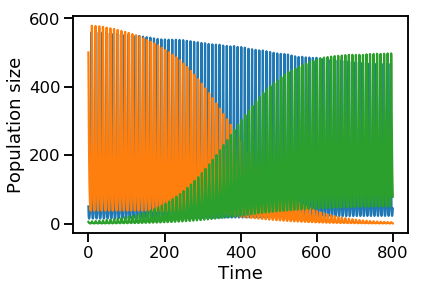

In [19]:
h2 = 0.0051 # h1 = 0.005
solve_plot(50, 500, 5, 800, b, h1, h2, ϵ, d)

We can see that even with ~2% hunting rate improvement the invasive is sucessful

## Stability

We saw in class the NE of the system without the invasive predator. We got that: 

$$
x^* = \frac{d}{\epsilon h_1} \\
y_1^* = \frac{b}{h_1}
$$
